## MonReader

In this project, images containing document pages being flipped or being held straight (no flipping) are used to train a Convolutional Neural Network which is then used to predict if pages are being flipped or not in test images.

In [1]:
import os
import shutil #file management module
import cv2 #openCV module
import pywt #wavelet transform module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix

## Define paths containing training and testing images

In [2]:
#define paths which contain training and testing images
training_data_path = './images/training/'
testing_data_path = './images/testing/'

## Visualize images

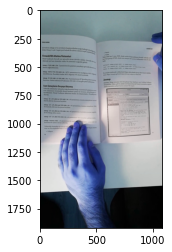

In [3]:
#An example of an image of pages NOT being flipped
img_test = cv2.imread('./test/noflip.jpg')
plt.imshow(img_test, cmap='gray')

In [4]:
img_test.shape

(1920, 1080, 3)

## Image cropping to remove extraneous objects like the hands

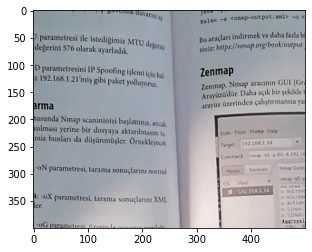

In [5]:
# we will crop each image to remove any extraneuous and irrelevent objects such as hands  and dark areas corresponding to 
# the floor (see above)

img_test_crop = img_test[500:900, 250:750]
plt.imshow(img_test_crop)

In [6]:
img_test_crop.shape

(400, 500, 3)

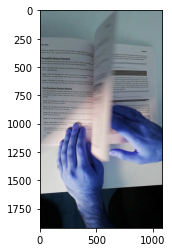

In [7]:
# An example of an image where the page is being flipped
img_test2 = cv2.imread('./test/flip.jpg')
plt.imshow(img_test2, cmap='gray')

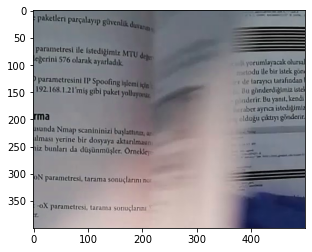

In [8]:
# cropped portion of the above image 
img_test2_crop = img_test2[500:900, 250:750]
plt.imshow(img_test2_crop)

## Create lists of directories containing training and testing images

In [9]:
#create a list of directories that contain TRAINING images
training_img_dirs = []
for entry in os.scandir(training_data_path):
    if entry.is_dir: #if entry is a directory
        training_img_dirs.append(entry.path) #append the directory path to the list

In [10]:
training_img_dirs

['./images/training/flip', './images/training/notflip']

In [11]:
#create a list of directories that containing TESTING images
testing_img_dirs = []

for entry in os.scandir(testing_data_path):
    if entry.is_dir:
        testing_img_dirs.append(entry.path)

In [12]:
testing_img_dirs

['./images/testing/flip', './images/testing/notflip']

All images in the training and testing datasets were cropped and examined by eye to ensure that the cropped region included mostly the pages and could be used in the model below

## Crop and resize all images and stack them in an array for training the Convolutional Neural Network model

## 1) Training images (NOTE! RUN THIS BLOCK OF CODE ONLY IF THE STACKED NORMALIZED ARRAYS (SEE BELOW) CANNOT BE USED IN THE CN MODEL. OTHERWISE USE THE SAVED ARRAYS TO SAVE TIME)

In [13]:
# for the training data, create an array consisting of the stacked arrays of cropped and resized original images along with and 
# list of labels (flip = 1 or nonflip = 0) for each image

X_train = np.empty(shape = (0,200,250,3)) # independent variable array
y_train = [] # dependent varibale list

for img_dir in training_img_dirs:
    for file in os.scandir(img_dir):
#         fil = file.path
#         print(fil[23:])
        img = cv2.imread(file.path)[500:900, 250:750] #read the image file and then crop it to the pparoximate centre
        scaled_img = cv2.resize(img, (250,200)) #resize the image to about half of the cropped image
        X_train = np.vstack((X_train,scaled_img.reshape(1,200,250,3)))#stack to X_train
        #create y list (dependent varibale)
        if 'notflip' in img_dir:
            y_train.append(0)
        else:
            y_train.append(1)   

In [14]:
y_train = np.array(y_train).astype('float16')
y_train

array([1., 1., 1., ..., 0., 0., 0.], dtype=float16)

In [15]:
X_train.shape

(2392, 200, 250, 3)

In [139]:
#normalize X_train
X_train_norm = X_train/255

## Save the stacked, normalized TRAINING X and y arrays into files

In [134]:
# Save the normalized array above so that it can be loaded later without having to rerun the code
np.save('X_train_norm.npy',X_train_norm)

In [135]:
test_array = np.load('X_train_norm.npy')

In [138]:
False in (test_array == X_train_norm) # saved array loaded into test_array is identical to the original array

False

In [140]:
np.save('y_train.npy',y_train)

## Load saved training arrays

In [13]:
X_train_norm = np.load('X_train_norm.npy')
y_train = np.load('y_train.npy')

## 2) Testing images (NOTE! RUN THIS BLOCK OF CODE ONLY IF THE STACKED NORMALIZED ARRAYS (SEE BELOW) CANNOT BE USED IN THE CN MODEL. OTHERWISE USE THE SAVED ARRAYS TO SAVE TIME)

In [18]:
#create similar arrays of stacked images as above but now for the testing images as well as labels

X_test = np.empty(shape = (0,200,250,3)) # independent variable list
y_test = [] # dependent varibale list

for img_dir in testing_img_dirs:
    for file in os.scandir(img_dir):
        #print(file.path) #print the file path just to keep track of the progress
        img = cv2.imread(file.path)[500:900, 250:750] #read the image file
        scaled_img = cv2.resize(img, (250,200)) #resize the image
        X_test = np.vstack((X_test , scaled_img.reshape(1,200,250,3))) #stack to X_test
        #create the y list
        if 'notflip' in img_dir:
            y_test.append(0)
        else:
            y_test.append(1)

In [19]:
X_test.shape

(597, 200, 250, 3)

In [20]:
y_test = np.array(y_test).astype('float16')

In [21]:
#normalize X_test
X_test_norm = X_test/255

## Save the stacked normalized TESTING X and y arrays into files

In [141]:
np.save('X_test_norm.npy',X_test_norm)
np.save('y_test.npy', y_test)

## Load saved testing arrays

In [14]:
X_test_norm = np.load('X_test_norm.npy')
y_test = np.load('y_test.npy')

# Create a Generalized Convolutional Neural Network Model With Dropout Layers as well as Random Image Augmentation (Flip and Rotation)

In [54]:
# specify Random Horizontal Flip and Random Rotation (a random amount in the range -10%*2pi and +10%*2pi - see docs)
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1)
    ])

In [55]:
#setup the model
model3 = Sequential()

model3.add(data_aug) # add the augmentation layers created above

model3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (200,250,3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
          
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

In [56]:
#compile the model
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
         metrics=['accuracy'])

In [57]:
model3.fit(X_train_norm, y_train, epochs = 50) #needs about 50 epochs to reach 80% accuracy

Epoch 1/50
75/75 [==============================] - 115s 2s/step - loss: 0.8028 - accuracy: 0.5464
Epoch 2/50
75/75 [==============================] - 112s 1s/step - loss: 0.6785 - accuracy: 0.5673
Epoch 3/50
75/75 [==============================] - 113s 2s/step - loss: 0.6722 - accuracy: 0.5962
Epoch 4/50
75/75 [==============================] - 132s 2s/step - loss: 0.6784 - accuracy: 0.5635
Epoch 5/50
75/75 [==============================] - 148s 2s/step - loss: 0.6839 - accuracy: 0.5598
Epoch 6/50
75/75 [==============================] - 140s 2s/step - loss: 0.6628 - accuracy: 0.6016
Epoch 7/50
75/75 [==============================] - 134s 2s/step - loss: 0.6571 - accuracy: 0.5991
Epoch 8/50
75/75 [==============================] - 128s 2s/step - loss: 0.6623 - accuracy: 0.5828
Epoch 9/50
75/75 [==============================] - 121s 2s/step - loss: 0.6467 - accuracy: 0.6175
Epoch 10/50
75/75 [==============================] - 114s 2s/step - loss: 0.6458 - accuracy: 0.6200
Epoch 11/

# Classify test images

In [58]:
#convert predicted values above 0.5 to 1. Lower values converted to 0.
y_pred = (model3.predict(X_test_norm)>0.5).astype('int16')

In [59]:
y_pred[280:300] # predictions where images transition from 'flip' to 'notflip'

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int16)

In [60]:
print(classification_report(y_test, y_pred)) # the classification metrics are reach about 80% overalx

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84       307
         1.0       0.99      0.60      0.75       290

    accuracy                           0.81       597
   macro avg       0.86      0.80      0.80       597
weighted avg       0.86      0.81      0.80       597



In [61]:
print(confusion_matrix(y_test, y_pred))

[[306   1]
 [115 175]]


All classification metrics are very good

## Create a function to classify if a single image where the page is being flipped or not

In [62]:
# function to predict if a page is being flipped or not using a single image (provide file path and file name)

def predict_flip (image, print_output):
    img = cv2.imread(image)[500:900, 250:750]# read and crop the image as before
    scaled_img = cv2.resize(img, (250,200))
    img_norm = (scaled_img/255).reshape(1,200,250,3)
    y_pred = (model3.predict(img_norm)>0.5).astype('int16')

    if print_output == 'Y':
        if y_pred == 0:
            print('This is not an image of page flipping')
        else: print('This is an image of a page being flipped')
    else: return y_pred

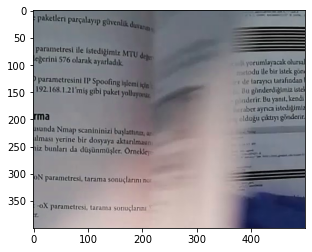

In [30]:
# test the following image of a page being flipped in the model
img_flip = cv2.imread('./test/flip.jpg')[500:900, 250:750]
plt.imshow(img_flip, cmap='gray')

In [63]:
predict_flip('./test/flip.jpg', 'Y') #the model correctly predicts an image where the page is being flipped

This is an image of a page being flipped


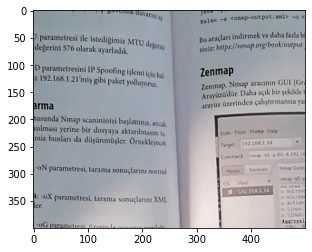

In [32]:
# test the following image of a page not flipped in the model
img_noflip = cv2.imread('./test/noflip.jpg')[500:900, 250:750]
plt.imshow(img_noflip, cmap='gray')

In [64]:
predict_flip('./test/noflip.jpg', 'Y') #the model correctly predicts an image where the page is not being flipped

This is not an image of page flipping


## Create a function to detect if a sequence of images contain an image where the page is being flipped

In [34]:
# function to predict if a series of images contain an image of a page being flipped. Folder containing the images to be 
# provided as folder path

def image_series (folder_path):
    X_seq = np.empty(shape = (0,200,250,3))
    for file in os.scandir(folder_path):
        img = cv2.imread(file.path)[500:900, 250:750] #read and crop the image
        scaled_img = cv2.resize(img, (250,200))
        img_norm = (scaled_img/255).reshape(1,200,250,3)
        X_seq = np.vstack((X_seq,img_norm))#stack
        y_predict = (model3.predict(X_seq)>0.5).astype('int16')
        
    if 1 in y_predict:
        print('Flipping action is detected in the image sequence')
    else: print('Flipping action is NOT detected in the image sequence')
    return y_predict

In [35]:
img_seq_path = './test_sequence/'

In [36]:
image_series(img_seq_path) #the image sequence has several images where the page is being turned (5 images).
# This is correctly identified by the above function using the trained model

Flipping action is detected in the image sequence


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int16)

## Test the model's ability to classify images taken by me

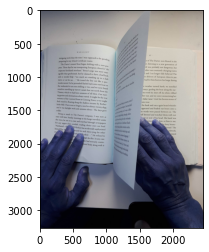

In [37]:
for file in os.scandir('./my_images/'):
    img_plt = cv2.imread(file.path)
    plt.imshow(img_plt, cmap='gray')

In [38]:
img_plt.shape

(3264, 2448, 3)

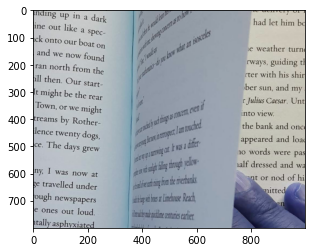

In [39]:
#similar to the original images from the dataset, following cropping will be done to exclude the hands as much as possible
img_plt_crop = img_plt[1000:1800,750:1750]
plt.imshow(img_plt_crop, cmap='gray')

In [40]:
# create a separate function to read, crop and resize the images taken by me
def predict_flip2 (image, print_output):
    img = cv2.imread(image)[1000:1800, 750:1750]
    scaled_img = cv2.resize(img, (250,200))
    img_norm = (scaled_img/255).reshape(1,200,250,3)
    y_pred = (model3.predict(img_norm)>0.5).astype('int16')
    # y_pred = model2.predict(img_norm)
    #print(y_pred[0])
    if print_output == 'Y':
        if y_pred == 0:
            print('This is not an image of page flipping')
        else: print('This is an image of a page being flipped')
    else: return y_pred

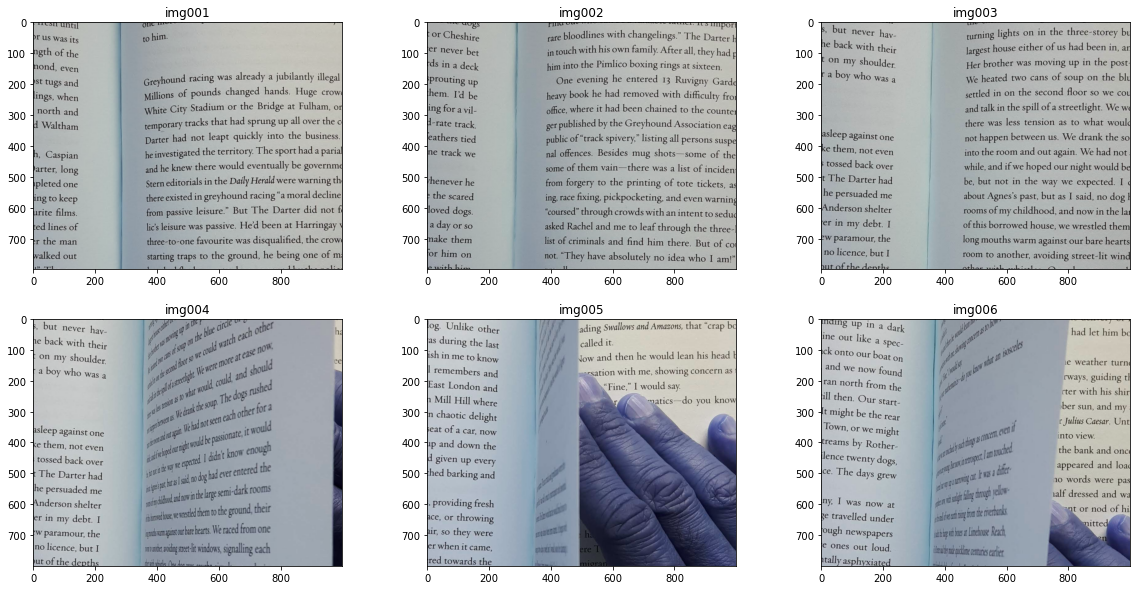

In [41]:
#following 6 test images taken by me were tested using the model

ind = 1
plt.subplots(figsize=(20,10))
for file in os.scandir('./my_images/'):
    plt.subplot(2, 3, ind)
    img_plt = cv2.imread(file.path)[1000:1800, 750:1750]
    plt.imshow(img_plt, cmap='gray')
    plt.title('img00'+str(ind))
    ind +=1

In [65]:
for file in os.scandir('./my_images/'):
    print('IMG FILE: ',file.path)
    predict_flip2(file.path, 'Y')
    
# surprisingly, all the test images were classified correctly when random image augmentation was applied

IMG FILE:  ./my_images/img001.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img002.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img003.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img004.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img005.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img006.jpg
This is an image of a page being flipped


## My Thoughts

## Saving the trained model

In [67]:
!mkdir -p saved_model #create a directory to save the model

In [70]:
model3.save('./saved_model/augmentation_model', save_format = 'h5') # with augmentation layers, must use the save_format='h5' to avoid error

In [73]:
# model can be loaded as follows:
model_test = tf.keras.models.load_model('./saved_model/augmentation_model')

model_test.get_weights()# get weights of the loaded model (weights not displayed in this notebook)

In [82]:
#create a new function to predict flipping using the loaded model

def predict_flip3 (image, print_output):
    img = cv2.imread(image)[1000:1800, 750:1750]
    scaled_img = cv2.resize(img, (250,200))
    img_norm = (scaled_img/255).reshape(1,200,250,3)
    y_pred = (model_test.predict(img_norm)>0.5).astype('int16')
    # y_pred = model2.predict(img_norm)
    #print(y_pred[0])
    if print_output == 'Y':
        if y_pred == 0:
            print('This is not an image of page flipping')
        else: print('This is an image of a page being flipped')
    else: return y_pred

In [84]:
# check the functionality of the loaded model by classifying the images taken by me.
for file in os.scandir('./my_images/'):
    print('IMG FILE: ',file.path)
    predict_flip3(file.path, 'Y')
#the loaded model perfomrs as expected

IMG FILE:  ./my_images/img001.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img002.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img003.jpg
This is not an image of page flipping
IMG FILE:  ./my_images/img004.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img005.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img006.jpg
This is an image of a page being flipped
